*****
*****
# Model Training on Dataset Version 1 (small)
**Multi-label classification dataset (including Binary Classification and Multi-class Classification)**

**Dataset Details:**
- 75000 samples
- 28 features
- 2 targets
  - 5 different class (1 safe, 4 diffrent malicious)
  - binary class (0-safe, 1-malicous)

*****

In [1]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install torch
!pip install torchinfo
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

*****
# Necessary Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import time
import json
import copy
import warnings
import joblib

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, train_test_split
from sklearn.metrics import(
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve, log_loss
)

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

import torch
import optuna
import torch.nn as nn
import torch.optim as optim

from optuna.trial import Trial
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [4]:
# check for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using : {torch.cuda.get_device_name(0) if device.type == 'cuda' else 'cpu'}")

Using : cpu


In [5]:
np.random.seed(42)
torch.manual_seed(42)

*****
# Dataset Import

In [3]:
import os
import time
import json
import copy
import warnings
import joblib

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, train_test_split
from sklearn.metrics import(
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve, log_loss
)

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

import torch

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [4]:
# dataset imports
path = '/content/drive/MyDrive/datasets/v1/'  # global path
X_train = pd.read_csv(path+'X_train.csv')
y_train = pd.read_csv(path+'y_train.csv')
X_test = pd.read_csv(path+'X_test.csv')
y_test = pd.read_csv(path+'y_test.csv')

*****
# Helper Functions

In [5]:
def measure_time(sec, name, Tune=False):
    """ Measure the time taken for training the model """
    hours, rem = divmod(sec, 3600)
    minutes, seconds = divmod(rem, 60)
    if Tune:
        print(f"{name} Hyperparameter Tuning Time: {int(hours)}h {int(minutes)}m {int(seconds)}s \n")
    else:
        print(f"{name} Training Time: {int(hours)}h {int(minutes)}m {int(seconds)}s \n")


def train_base_model(model, name, X_train, y_train, X_test, y_test):
    """ Train the model and print the training and test accuracy """
    """ Print the training and test accuracy of the model """
    model = MultiOutputClassifier(model)
    model.fit(X_train, y_train)

    train = model.predict(X_train)
    test = model.predict(X_test)

    train_multi = accuracy_score(y_train['Attack Type'], train[:,0])
    train_binary = accuracy_score(y_train['status'], train[:,1])
    test_multi = accuracy_score(y_test['Attack Type'], test[:,0])
    test_acc2 = accuracy_score(y_test['status'], test[:,1])

    print(f"{name} =====================================================")
    print(f"Train Accuracy- Multi-class: {train_multi:.4}, Binary: {train_binary:.4}, Average: {((train_multi+train_binary)/2):.4}")
    print(f"Test Accuracy- Multi-class: {test_multi:.4}, Binary: {test_acc2:.4}, Average: {((test_multi+test_acc2)/2):.4}")


def perform_hyperparameter_tuning(model, parameters, X_train, y_train):
    """ Perform hyperparameter tuning on the model """
    """ Return the best model and best parameters """
    model = MultiOutputClassifier(model)
    grid_search = GridSearchCV(
        estimator= model,
        param_grid=parameters,
        cv=5,
        scoring='accuracy',
        verbose=3,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    print("\nBest Parameters:", best_params)
    return best_params

def test_model(model, test_loader, device):
    """ evaluates the trained model on the test dataset for both multi-class and binary classification task. """
    model.eval()  # enable evaluation mode
    correct = 0
    correct_binary = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y_multi, batch_y_binary in test_loader:
            batch_X, batch_y_multi, batch_y_binary =  batch_X.to(device), batch_y_multi.to(device), batch_y_binary.to(device)

            # forward pass
            pred_multi, pred_binary = model(batch_X)

            # predictions
            _, predicted_multi = torch.max(pred_multi, 1) # modified remove .data
            predicted_binary = (pred_binary > 0.5).float()

            # calculate accuracy
            correct += (predicted_multi == batch_y_multi).sum().item()
            correct_binary += (predicted_binary == batch_y_binary).sum().item()
            total += batch_y_multi.size(0)

    print(f"Test Multi-class Accuracy: {correct/total:.4f}")
    print(f"Test Binary Accuracy: {correct_binary/total:.4f}")
    print(f"Test Average Accuracy: {((correct/total) + (correct_binary/total)) / 2}")


def get_model_params(model):
    """ returns the number of trainable parameters in the model """
    print(f"Total Number of Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

In [6]:
def check_metrics(model, name, X_train, y_train, X_test, y_test):
    """ check accuracy, loss, precision, recall, f1-score, tpr, fpr, confusion matrix and precision-recall curve for test data """
    def get_predictions(model, X, y):
        """ get the predictions for the given model one data X & y """
        true_multi = y['Attack Type'].values
        true_binary = y['status'].values

        # get predictions
        pred = model.predict(X)
        pred_multi = pred[:, 0] # multi-class predictions
        pred_binary = pred[:, 1] # binary predictions

        # get probabilities if the model supports
        prob_multi = None
        prob_binary = None
        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(X)
            prob_multi = proba[0] # multi-class probabilities
            prob_binary = proba[1][:, 1] # binary probabilities

        return pred_multi, pred_binary, true_multi, true_binary, prob_multi, prob_binary

    ## ========================================================================================================= ##
    ## title
    print("="*100)
    print(" "*40 + "\033[1;34m" + name.upper() + " REPORT" + "\033[0m" + " "*10)
    print("="*100)

    ## ========================================================================================================= ##
    # get predictions
    train_pred_multi, train_pred_binary, train_true_multi, train_true_binary, train_prob_multi, train_prob_binary = get_predictions(model, X_train, y_train)
    test_pred_multi, test_pred_binary, test_true_multi, test_true_binary, test_prob_multi, test_prob_binary = get_predictions(model, X_test, y_test)

    # calculate accuracies
    train_acc_multi = accuracy_score(train_true_multi, train_pred_multi)
    train_acc_binary = accuracy_score(train_true_binary, train_pred_binary)
    train_acc_avg = (train_acc_binary + train_acc_multi) / 2
    test_acc_multi = accuracy_score(test_true_multi, test_pred_multi)
    test_acc_binary = accuracy_score(test_true_binary, test_pred_binary)
    test_acc_avg = (test_acc_binary + test_acc_multi) / 2

    # calculate losses
    train_loss_multi = log_loss(train_true_multi, train_prob_multi) if train_prob_multi is not None else float('nan')
    train_loss_binary = log_loss(train_true_binary, train_prob_binary) if train_prob_binary is not None else float('nan')
    train_loss_avg = (train_loss_multi + train_loss_binary) / 2
    test_loss_multi = log_loss(test_true_multi, test_prob_multi) if test_prob_multi is not None else float('nan')
    test_loss_binary = log_loss(test_true_binary, test_prob_binary) if test_prob_binary is not None else float('nan')
    test_loss_avg = (train_loss_multi + train_loss_binary) / 2

    ## ========================================================================================================= ##
    # Print accuracy report
    print("="*100)
    print(f"\n{'':<35} < === Accuracy & Loss Report === >")
    print()
    print(f"{'':<20}   Multi-class  |   Binary   |   Average")
    print(f"Training Accuracy:   {train_acc_multi:10.4f}     |   {train_acc_binary:6.4f}   |   {train_acc_avg:6.4f}")
    print(f"Test Accuracy:       {test_acc_multi:10.4f}     |   {test_acc_binary:6.4f}   |   {test_acc_avg:6.4f}")
    print("                            -       |      -     |      -")
    print(f"Training Loss:       {train_loss_multi:10.4f}     |   {train_loss_binary:6.4f}   |   {train_loss_avg:6.4f}")
    print(f"Test Loss:           {test_loss_multi:10.4f}     |   {test_loss_binary:6.4f}   |   {test_loss_avg:6.4f}")
    print()

    ## ========================================================================================================= ##
    # Binary Classification | test set metrics
    # calculate tpr & fpr for binary classification
    tn, fp, fn, tp = confusion_matrix(test_true_binary, test_pred_binary).ravel()
    tpr_binary = (tp / (tp + fn)).item()
    fpr_binary = (fp / (fp + tn)).item()

    precision_binary = precision_score(test_true_binary, test_pred_binary)
    recall_binary = recall_score(test_true_binary, test_pred_binary)
    f1_binary = f1_score(test_true_binary, test_pred_binary)

    print("="*100)
    print(f"\n{'':<32} < === Binary Classification Report === >")
    print()
    print(f"Precision: {precision_binary:.4f}")
    print(f"Recall: {recall_binary:.4f}")
    print(f"F1 Score: {f1_binary:.4f}")

    print(f"True Positive Rate: {tpr_binary:.4f}")
    print(f"False Positive Rate: {fpr_binary:.4f}")
    print()

    # plot confusion matrix
    cm_binary = confusion_matrix(test_true_binary, test_pred_binary)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues')
    plt.title('Binary Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()

    # binary precision-recall curve
    if test_prob_binary is not None:
        precision, recall, _ = precision_recall_curve(test_true_binary, test_prob_binary)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, marker='.')
        plt.title('Binary Classification Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
        plt.show()
    else:
        print("Precision-Recall curve for binary classification skipped (model does not support predict_proba)")
    print()

    ## ========================================================================================================= ##
    # Multi-class Classification | test set metrics
    # calculate tpr & fpr for binary classification
    tpr_list = []
    fpr_list = []
    output_class = len(np.unique(test_true_multi))
    for i in range(output_class):
        # convert multiclass labels to binary
        y_true_binary = (test_true_multi == i).astype(int)
        y_pred_binary = (test_pred_multi == i).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    tpr_multi = np.mean(tpr_list).item()
    fpr_multi = np.mean(fpr_list).item()
    precision_multi = precision_score(test_true_multi, test_pred_multi, average='weighted')
    recall_multi = recall_score(test_true_multi, test_pred_multi, average='weighted')
    f1_multi = f1_score(test_true_multi, test_pred_multi, average='weighted')

    print("="*100)
    print(f"\n{'':<26} < === Multi-class Classification Report === >")
    print()
    print(f"Precision: {precision_multi:.4f}")
    print(f"Recall: {recall_multi:.4f}")
    print(f"F1 Score: {f1_multi:.4f}")
    print(f"True Positive Rate: {tpr_multi:.4f}")
    print(f"False Positive Rate: {fpr_multi:.4f}")
    print()

    # plot confusion matrix
    cm_multi = confusion_matrix(test_true_multi, test_pred_multi)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
    plt.title('Multi-class Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()

    # multi-class precision-recall curve
    if test_prob_multi is not None:
        plt.figure(figsize=(8, 5))
        for i in range(output_class):
            # Binarize true labels for class i
            true_binary = (test_true_multi == i).astype(int)
            prob_class = test_prob_multi[:, i]
            precision, recall, _ = precision_recall_curve(true_binary, prob_class)
            plt.plot(recall, precision, label=f"Class {i}")
        plt.title('Multi-class Classification Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(title='class', loc='best')
        plt.grid(True)
        plt.show()
    else:
        print("Precision-Recall curve for binary classification skipped (model does not support predict_proba)")
    print()

    ## ========================================================================================================= ##
    # Average Results | test set metrics


    tpr_avg = ((tpr_binary + tpr_multi) / 2)
    fpr_avg = ((fpr_binary + fpr_multi) / 2)

    precision_avg = (precision_binary + precision_multi) / 2
    recall_avg = (recall_binary + recall_multi) / 2
    f1_avg = (f1_binary + f1_multi) / 2

    print("="*100)
    print(f"\n{'':<30} < === Average Classification Report === >")
    print()
    print(f"Precision: {precision_avg:.4f}")
    print(f"Recall: {recall_avg:.4f}")
    print(f"F1 Score: {f1_avg:.4f}")

    print(f"True Positive Rate: {tpr_avg:.4f}")
    print(f"False Positive Rate: {fpr_avg:.4f}")
    print("="*100)

    # return 3 tuples -> binary_classification_report, multi_classification_report, avg_classification_report
    return ((train_acc_binary, test_acc_binary, train_loss_binary, test_loss_binary, f1_binary, precision_binary, recall_binary, tpr_binary, fpr_binary),
            (train_acc_multi, test_acc_multi, train_loss_multi, test_loss_multi, f1_multi, precision_multi, recall_multi, tpr_multi, fpr_multi),
            (train_acc_avg, test_acc_avg, train_loss_avg, test_loss_avg, f1_avg, precision_avg, recall_avg, tpr_avg, fpr_avg))

def evaluate_dnn_result(model, name, train_loader, test_loader, output_class, device):
    """ evaluate the deep neural network model on training, and test set for mlp and cnn models """
    """ print the training, and test set accuracy first """
    """ print the classification report (accuracy, precision, recall, f1-score, tpr, fpr), confusion matrix
        and precision-recall curve for multi-class and binary classification """

    def get_prediction(loader):
        """ get the predicitons for the model """
        total_pred_multi = []
        total_pred_binary = []
        total_true_multi = []
        total_true_binary = []
        total_prob_multi = []
        total_prob_binary = []

        model.eval()  # enable evaluation mode
        with torch.no_grad():
            for batch_X, batch_y_multi, batch_y_binary in loader:
                batch_X, batch_y_multi, batch_y_binary =  batch_X.to(device), batch_y_multi.to(device), batch_y_binary.to(device)

                # forward pass
                pred_multi, pred_binary = model(batch_X)

                # prediction
                _, predicted_multi = torch.max(pred_multi, 1) # modified remove .data
                predicted_binary = (pred_binary > 0.5).float()

                # move to cpu and convert to numpy
                total_pred_multi.extend(predicted_multi.cpu().numpy())
                total_pred_binary.extend(predicted_binary.cpu().numpy().flatten())
                total_true_multi.extend(batch_y_multi.cpu().numpy())
                total_true_binary.extend(batch_y_binary.cpu().numpy().flatten())
                total_prob_multi.extend(torch.softmax(pred_multi, dim=1).cpu().numpy())
                total_prob_binary.extend(pred_binary.cpu().numpy().flatten())

        return np.array(total_pred_multi), np.array(total_pred_binary), np.array(total_true_multi), np.array(total_true_binary), np.array(total_prob_multi), np.array(total_prob_binary)


    ## ========================================================================================================= ##
    ## title
    print("="*100)
    print(" "*40 + "\033[1;34m" + name.upper() + " REPORT" + "\033[0m" + " "*10)
    print("="*100)

    ## ========================================================================================================= ##
    # get predictions
    train_pred_multi, train_pred_binary, train_true_multi, train_true_binary, train_prob_multi, train_prob_binary = get_prediction(train_loader)
    test_pred_multi, test_pred_binary, test_true_multi, test_true_binary, test_prob_multi, test_prob_binary = get_prediction(test_loader)

    # calculate accuracies
    train_acc_multi = accuracy_score(train_true_multi, train_pred_multi)
    train_acc_binary = accuracy_score(train_true_binary, train_pred_binary)
    train_acc_avg = (train_acc_binary + train_acc_multi) / 2
    test_acc_multi = accuracy_score(test_true_multi, test_pred_multi)
    test_acc_binary = accuracy_score(test_true_binary, test_pred_binary)
    test_acc_avg = (test_acc_binary + test_acc_multi) / 2

    # calculate losses
    train_loss_multi = log_loss(train_true_multi, train_prob_multi) if train_prob_multi is not None else float('nan')
    train_loss_binary = log_loss(train_true_binary, train_prob_binary) if train_prob_binary is not None else float('nan')
    train_loss_avg = (train_loss_multi + train_loss_binary) / 2
    test_loss_multi = log_loss(test_true_multi, test_prob_multi) if test_prob_multi is not None else float('nan')
    test_loss_binary = log_loss(test_true_binary, test_prob_binary) if test_prob_binary is not None else float('nan')
    test_loss_avg = (train_loss_multi + train_loss_binary) / 2

    ## ========================================================================================================= ##
    # Print accuracy report
    print("="*100)
    print(f"\n{'':<35} < === Accuracy & Loss Report === >")
    print()
    print(f"{'':<20}   Multi-class  |   Binary   |   Average")
    print(f"Training Accuracy:   {train_acc_multi:10.4f}     |   {train_acc_binary:6.4f}   |   {train_acc_avg:6.4f}")
    print(f"Test Accuracy:       {test_acc_multi:10.4f}     |   {test_acc_binary:6.4f}   |   {test_acc_avg:6.4f}")
    print("                            -       |      -     |      -")
    print(f"Training Loss:       {train_loss_multi:10.4f}     |   {train_loss_binary:6.4f}   |   {train_loss_avg:6.4f}")
    print(f"Test Loss:           {test_loss_multi:10.4f}     |   {test_loss_binary:6.4f}   |   {test_loss_avg:6.4f}")
    print()

    ## ========================================================================================================= ##
    # Binary Classification | test set metrics
    # calculate tpr & fpr for binary classification
    tn, fp, fn, tp = confusion_matrix(test_true_binary, test_pred_binary).ravel()
    tpr_binary = (tp / (tp + fn)).item()
    fpr_binary = (fp / (fp + tn)).item()

    precision_binary = precision_score(test_true_binary, test_pred_binary)
    recall_binary = recall_score(test_true_binary, test_pred_binary)
    f1_binary = f1_score(test_true_binary, test_pred_binary)

    print("="*100)
    print(f"\n{'':<32} < === Binary Classification Report === >")
    print()
    print(f"Precision: {precision_binary:.4f}")
    print(f"Recall: {recall_binary:.4f}")
    print(f"F1 Score: {f1_binary:.4f}")

    print(f"True Positive Rate: {tpr_binary:.4f}")
    print(f"False Positive Rate: {fpr_binary:.4f}")
    print()

    # plot confusion matrix
    cm_binary = confusion_matrix(test_true_binary, test_pred_binary)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues')
    plt.title('Binary Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()

    # binary precision-recall curve
    if test_prob_binary is not None:
        precision, recall, _ = precision_recall_curve(test_true_binary, test_prob_binary)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, marker='.')
        plt.title('Binary Classification Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
        plt.show()
    else:
        print("Precision-Recall curve for binary classification skipped (model does not support predict_proba)")
    print()

    ## ========================================================================================================= ##
    # Multi-class Classification | test set metrics
    # calculate tpr & fpr for binary classification
    tpr_list = []
    fpr_list = []
    output_class = len(np.unique(test_true_multi))
    for i in range(output_class):
        # convert multiclass labels to binary
        y_true_binary = (test_true_multi == i).astype(int)
        y_pred_binary = (test_pred_multi == i).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    tpr_multi = np.mean(tpr_list).item()
    fpr_multi = np.mean(fpr_list).item()
    precision_multi = precision_score(test_true_multi, test_pred_multi, average='weighted')
    recall_multi = recall_score(test_true_multi, test_pred_multi, average='weighted')
    f1_multi = f1_score(test_true_multi, test_pred_multi, average='weighted')

    print("="*100)
    print(f"\n{'':<26} < === Multi-class Classification Report === >")
    print()
    print(f"Precision: {precision_multi:.4f}")
    print(f"Recall: {recall_multi:.4f}")
    print(f"F1 Score: {f1_multi:.4f}")
    print(f"True Positive Rate: {tpr_multi:.4f}")
    print(f"False Positive Rate: {fpr_multi:.4f}")
    print()

    # plot confusion matrix
    cm_multi = confusion_matrix(test_true_multi, test_pred_multi)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
    plt.title('Multi-class Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()

    # multi-class precision-recall curve
    if test_prob_multi is not None:
        plt.figure(figsize=(8, 5))
        for i in range(output_class):
            # Binarize true labels for class i
            true_binary = (test_true_multi == i).astype(int)
            prob_class = test_prob_multi[:, i]
            precision, recall, _ = precision_recall_curve(true_binary, prob_class)
            plt.plot(recall, precision, label=f"Class {i}")
        plt.title('Multi-class Classification Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(title='class', loc='best')
        plt.grid(True)
        plt.show()
    else:
        print("Precision-Recall curve for binary classification skipped (model does not support predict_proba)")
    print()

    ## ========================================================================================================= ##
    # Average Results | test set metrics


    tpr_avg = ((tpr_binary + tpr_multi) / 2)
    fpr_avg = ((fpr_binary + fpr_multi) / 2)

    precision_avg = (precision_binary + precision_multi) / 2
    recall_avg = (recall_binary + recall_multi) / 2
    f1_avg = (f1_binary + f1_multi) / 2

    print("="*100)
    print(f"\n{'':<30} < === Average Classification Report === >")
    print()
    print(f"Precision: {precision_avg:.4f}")
    print(f"Recall: {recall_avg:.4f}")
    print(f"F1 Score: {f1_avg:.4f}")

    print(f"True Positive Rate: {tpr_avg:.4f}")
    print(f"False Positive Rate: {fpr_avg:.4f}")
    print("="*100)

    # return 3 tuples -> binary_classification_report, multi_classification_report, avg_classification_report
    return ((train_acc_binary, test_acc_binary, train_loss_binary, test_loss_binary, f1_binary, precision_binary, recall_binary, tpr_binary, fpr_binary),
            (train_acc_multi, test_acc_multi, train_loss_multi, test_loss_multi, f1_multi, precision_multi, recall_multi, tpr_multi, fpr_multi),
            (train_acc_avg, test_acc_avg, train_loss_avg, test_loss_avg, f1_avg, precision_avg, recall_avg, tpr_avg, fpr_avg))

In [7]:
def plot_learning_curve(model, X, y, name, version):
    """ get the model & dataset calculate the training and cross validation losses and plot the learning curve """
    def custom_neg_log_loss(model, X, y):
        """ custom loss function to calculate the negative log loss """
        y_pred_proba = model.predict_proba(X) # get probabilities
        total_loss = 0
        for i, y_label in enumerate(y.columns):
            y_pred = np.clip(y_pred_proba[i], 1e-15, 1 - 1e-15) # get the probabilities of both labels per iterations
            # calculate loss of both label per iterations
            loss = log_loss(y[y_label], y_pred)
            total_loss += loss
        return -total_loss / len(y.columns) # return the average loss

    # get loss values
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring= custom_neg_log_loss,
        train_sizes = np.linspace(0.1, 1.0, 50)
    )

    train_losses = -train_scores.mean(axis=1)
    val_losses = -val_scores.mean(axis=1)
    #train_std = train_scores.std(axis=1)
    #val_std = val_scores.std(axis=1)

    # debuging statements
    #print("Train size:", train_sizes)
    print("Train loss:", round(train_losses[-1], 4))
    print("Val loss:", round(val_losses[-1], 4))

    # ploting the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_losses, label='Training Loss')
    plt.plot(train_sizes, val_losses, label='Validation Loss (CV)')
    #plt.fill_between(train_sizes, train_losses - train_std, train_losses + train_std, alpha=0.1)
    #plt.fill_between(train_sizes, val_losses - val_std, val_losses + val_std, alpha=0.1)
    plt.title(f"{name} Learning Curve ({version})")
    plt.xlabel("Training Set Size")
    plt.ylabel("Losses")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_learning_curves(history, name, version):
    """ get the model history data as dictionary and plot the learning curve (loss & accuracy curves) """
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.title(f"{name} Learning Curve ({version})")
    plt.xlabel("Epochs")
    plt.ylabel('Losses')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print()
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_acc_multi'], label='Train Multi-class Acc')
    plt.plot(history['val_acc_multi'], label='Val Multi-class Acc')
    plt.plot(history['train_acc_binary'], label='Train Binary Acc')
    plt.plot(history['val_acc_binary'], label='Val Binary Acc')
    plt.plot(history['train_acc_avg'], label='Train Avg Acc')
    plt.plot(history['val_acc_avg'], label='Val Avg Acc')
    plt.title(f"{name} Accuracy Curve ({version})")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_training_curve(history):
    """ plot the learning curve of the final dnn """
    plt.figure(figsize=(8,6))
    plt.plot(history['train_losses'], label="Training Loss")
    plt.plot(history['train_acc_multi'], label='Train Multi-class Acc')
    plt.plot(history['train_acc_binary'], label='Train Binary Acc')
    plt.plot(history['train_acc_avg'], label='Train Avg Acc')
    plt.title(f"Deep Neural Network Training Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy/Losses")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:
def save_classification_reports(binary, multi, average, model_name, file_name):
    """ save the classification results into a json file """
    metrics = ["Train Acc", "Test Acc", "Train Loss", "Test Loss", "F1-score", "Precision", "Recall", "TPR", "FPR"]   # define the metrics keys

    # unpack the tuples
    binary_dict = {key: round(value, 4) for key, value in zip(metrics, binary)}
    multi_dict = {key: round(value, 4) for key, value in zip(metrics, multi)}
    avg_dict = {key: round(value, 4) for key, value in zip(metrics, average)}

    # structure the data
    model_data = {
        model_name: {
            "Binary Classification Results": binary_dict,
            "Multi-class Classification Results": multi_dict,
            "Average Classification Results": avg_dict
        }
    }
    try:
        if os.path.exists(file_name):  # check for file exists
            with open(file_name, 'r') as file:
                existing_data = json.load(file)
            existing_data.update(model_data)
        else:
            existing_data = model_data
        with open(file_name, 'w') as file:
            json.dump(existing_data, file, indent=4)
        print("Data saved successfully!")
    except Exception as e:
        print("Data not save!",e)

# Train base model on training set and evaluate on Test set. (Decision Tree, Random Forest, Naive Bayes)
printing the Training and Test set accuracy for each models.

In [ ]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    "KNN": KNeighborsClassifier()
}

for name, model in models.items():
  start = time.time()
  train_base_model(model, name, X_train, y_train, X_test, y_test)
  end = time.time()
  measure_time((end-start), name)

Decision Tree =====================================================
Train Accuracy- Multi-class: 0.9861, Binary: 0.9879, Average: 0.987
Test Accuracy- Multi-class: 0.9781, Binary: 0.98, Average: 0.9791
Decision Tree Training Time: 0h 0m 1s 

Random Forest =====================================================
Train Accuracy- Multi-class: 0.986, Binary: 0.9879, Average: 0.987
Test Accuracy- Multi-class: 0.9799, Binary: 0.9815, Average: 0.9807
Random Forest Training Time: 0h 0m 17s 

Naive Bayes =====================================================
Train Accuracy- Multi-class: 0.7879, Binary: 0.7386, Average: 0.7633
Test Accuracy- Multi-class: 0.788, Binary: 0.7368, Average: 0.7624
Naive Bayes Training Time: 0h 0m 0s 

AdaBoost =====================================================
Train Accuracy- Multi-class: 0.9061, Binary: 0.9527, Average: 0.9294
Test Accuracy- Multi-class: 0.9052, Binary: 0.9532, Average: 0.9292
AdaBoost Training Time: 0h 0m 9s 

KNN ===================================

*****
*****
# Decision Tree

In [ ]:
# performing hyperparameter tuning for Decision Tree model
dt_param_grid = {
    'estimator__criterion': ['gini', 'entropy', 'log_loss'],
    'estimator__max_depth': [10, 20, 30, 40, 50],
    'estimator__min_samples_split': [2, 5, 8, 10, 15],
    'estimator__min_samples_leaf': [1, 2, 4, 5, 8, 10],
}
start = time.time()
dt_best_params = perform_hyperparameter_tuning(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    X_train,
    y_train
)
measure_time((time.time()-start), "Decision Tree", True)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits

Best Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2}
Decision Tree Hyperparameter Tuning Time: 0h 29m 39s 



Train loss: 0.0941
Val loss: 0.1167


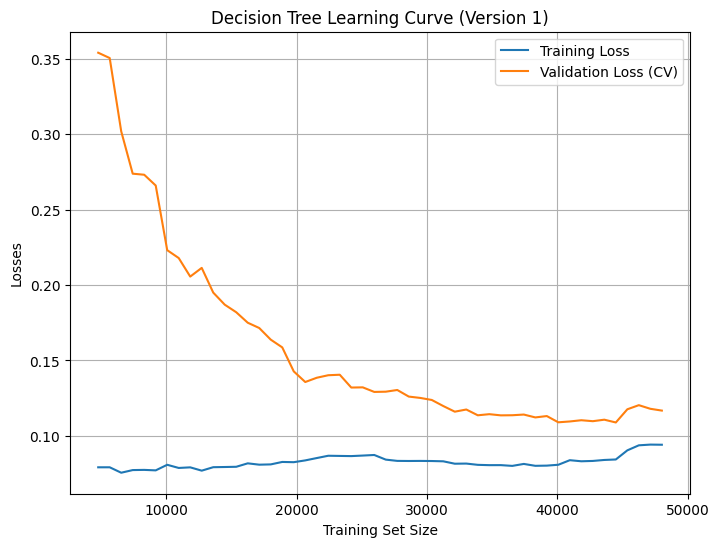

In [ ]:
# initialize the classifier
dt_best_params = {key.replace('estimator__', ''): value for key, value in dt_best_params.items()}
dt_classifier = MultiOutputClassifier(DecisionTreeClassifier(**dt_best_params, ccp_alpha=0.0001, random_state=42))

# ploting learning curve
plot_learning_curve(dt_classifier, X_train, y_train, 'Decision Tree', "Version 1")


                                        DECISION TREE REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.9718     |   0.9622   |   0.9670
Test Accuracy:           0.9707     |   0.9613   |   0.9660
                            -       |      -     |      -
Training Loss:           0.0766     |   0.1207   |   0.0987
Test Loss:               0.0921     |   0.1280   |   0.0987


                                 < === Binary Classification Report === >

Precision: 0.9564
Recall: 0.9972
F1 Score: 0.9763
True Positive Rate: 0.9972
False Positive Rate: 0.1822



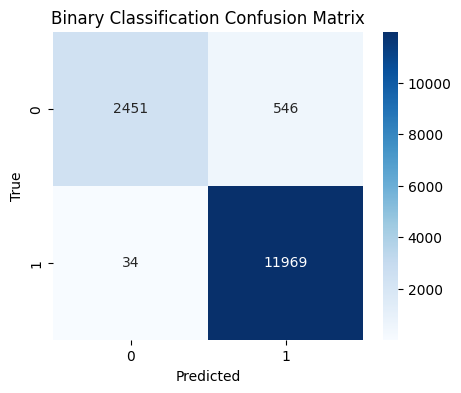

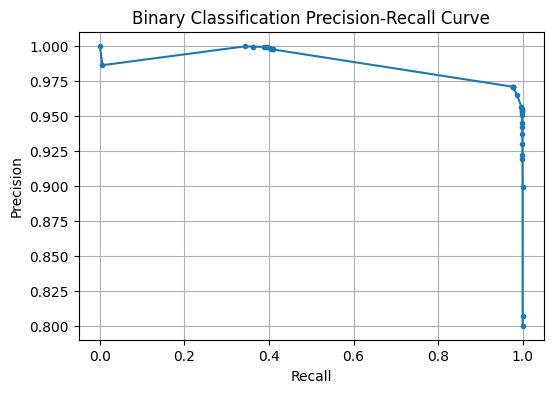



                           < === Multi-class Classification Report === >

Precision: 0.9709
Recall: 0.9707
F1 Score: 0.9707
True Positive Rate: 0.9708
False Positive Rate: 0.0073



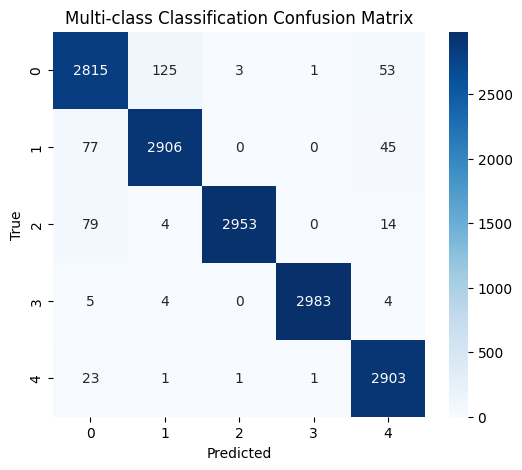

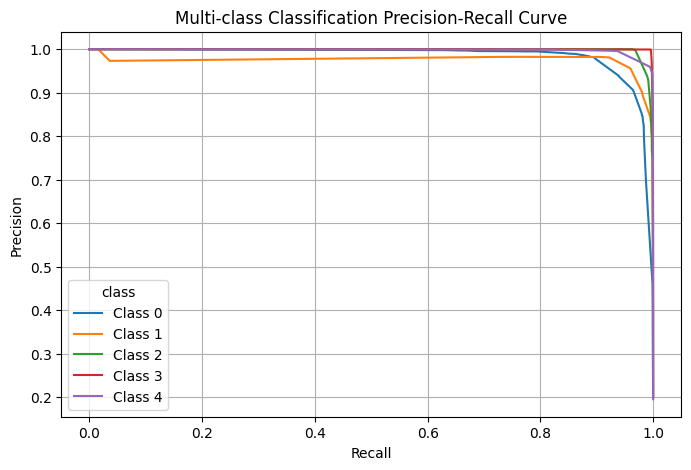



                               < === Average Classification Report === >

Precision: 0.9637
Recall: 0.9839
F1 Score: 0.9735
True Positive Rate: 0.9840
False Positive Rate: 0.0948


In [ ]:
# train the final model
dt_classifier.fit(X_train, y_train)

# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report, multi_classification_report, avg_classification_report = check_metrics(dt_classifier, "Decision Tree", X_train, y_train, X_test, y_test)

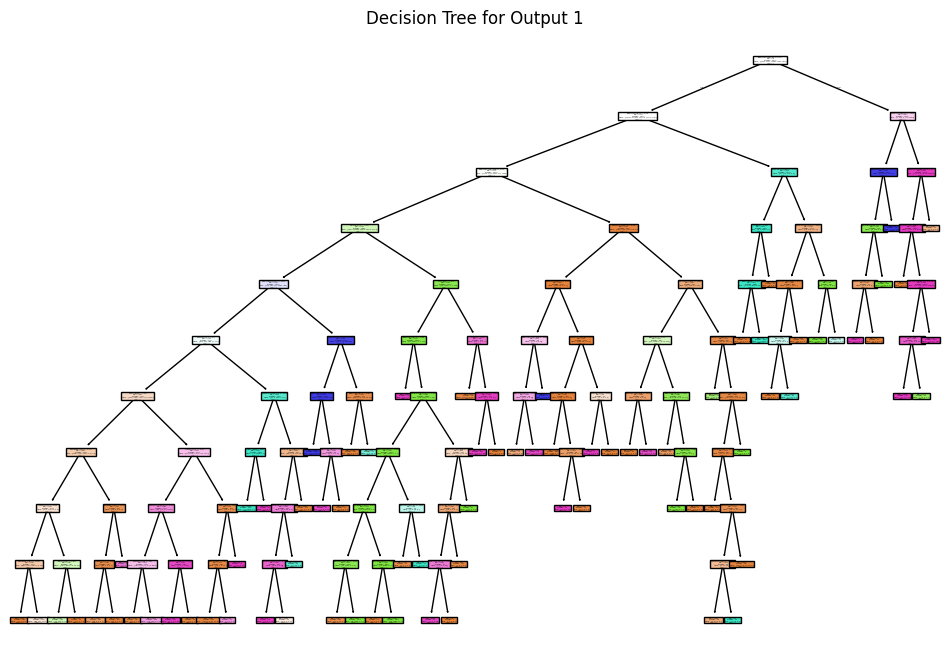

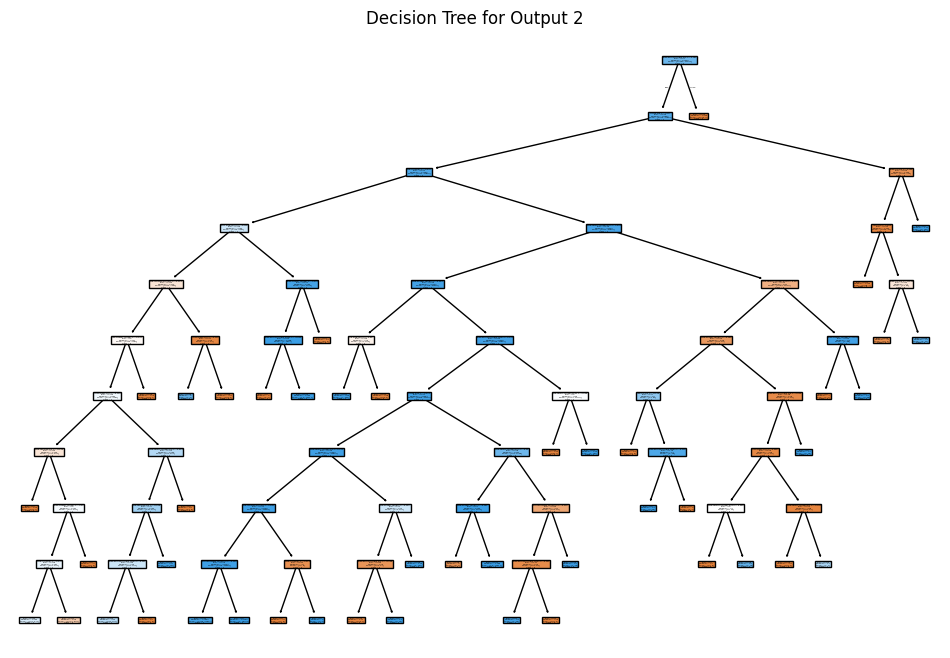

In [ ]:
from sklearn.tree import plot_tree

for i, tree in enumerate(dt_classifier.estimators_):
    plt.figure(figsize=(12, 8))

    class_names = [str(cls) for cls in tree.classes_] if hasattr(tree, "classes_") else None
    feature_names = X_train.columns if hasattr(X_train, "columns") else [f"Feature {j}" for j in range(X_train.shape[1])]

    plot_tree(tree, filled=True, feature_names=feature_names, class_names=class_names)
    plt.title(f"Decision Tree for Output {i+1}")
    plt.show()

In [ ]:
# write into json file
save_classification_reports(binary_classification_report, multi_classification_report, avg_classification_report, "Decision Tree", (path + "v1_results.json"))

Data saved successfully!


In [ ]:
# saving model
joblib.dump(dt_classifier, (path + 'dt_classifier.pkl'))

['/content/drive/MyDrive/datasets/dt_classifier.pkl']

*****
*****
# Random Forest

In [ ]:
# performing hyperparameter tuning for Random Forest model
rf_param_grid = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [10, 20, 30],
    'estimator__min_samples_split': [2, 5, 8, 10],
    'estimator__min_samples_leaf': [1, 2, 4, 5],
    'estimator__criterion': ['gini', 'log_loss']
}
start = time.time()
rf_best_params = perform_hyperparameter_tuning(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    X_train,
    y_train
)
measure_time((time.time()-start), "Random Foorest", True)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Best Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Random Foorest Hyperparameter Tuning Time: 3h 50m 23s 



Train loss: 0.0617
Val loss: 0.0644


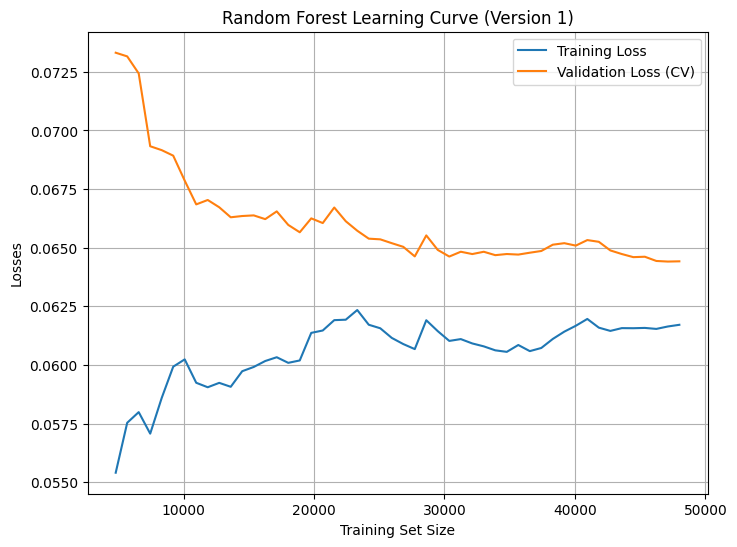

In [ ]:
# initialize the classifier
rf_best_params = {key.replace('estimator__', ''): value for key, value in rf_best_params.items()}
rf_classifier = MultiOutputClassifier(RandomForestClassifier(**rf_best_params, ccp_alpha=0.0001, random_state=42))

# ploting learning curve
plot_learning_curve(rf_classifier, X_train, y_train, 'Random Forest', "Version 1")

                                        RANDOM FOREST REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.9748     |   0.9788   |   0.9768
Test Accuracy:           0.9744     |   0.9779   |   0.9761
                            -       |      -     |      -
Training Loss:           0.0674     |   0.0584   |   0.0629
Test Loss:               0.0711     |   0.0594   |   0.0629


                                 < === Binary Classification Report === >

Precision: 0.9749
Recall: 0.9980
F1 Score: 0.9863
True Positive Rate: 0.9980
False Positive Rate: 0.1028



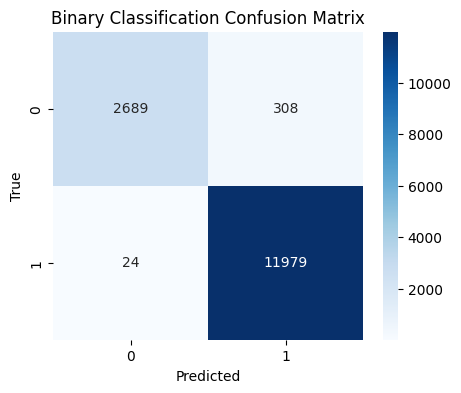

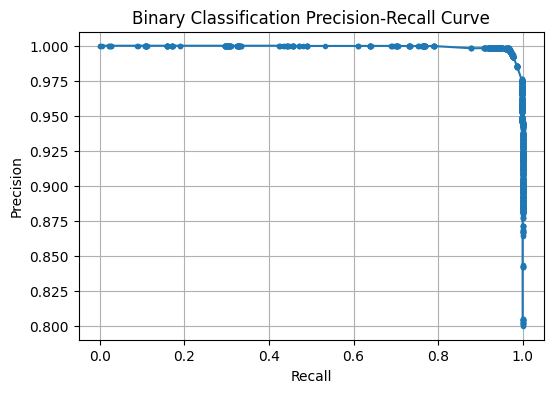



                           < === Multi-class Classification Report === >

Precision: 0.9750
Recall: 0.9744
F1 Score: 0.9746
True Positive Rate: 0.9745
False Positive Rate: 0.0064



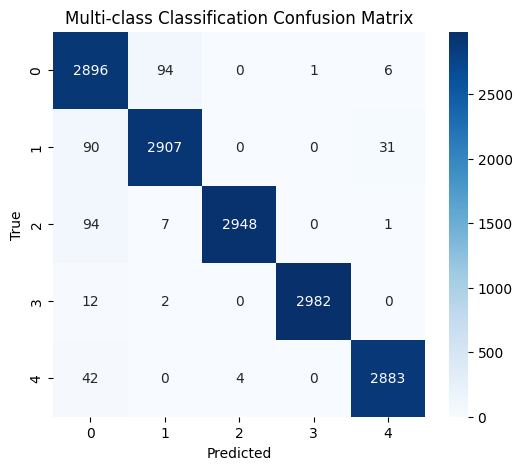

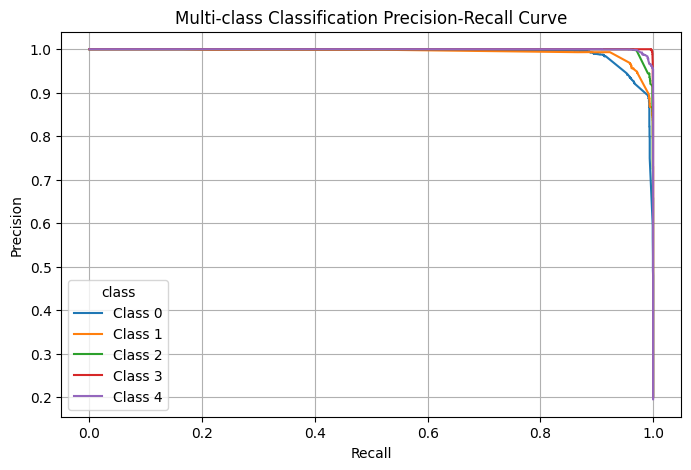



                               < === Average Classification Report === >

Precision: 0.9750
Recall: 0.9862
F1 Score: 0.9804
True Positive Rate: 0.9863
False Positive Rate: 0.0546


In [ ]:
# train the final model
rf_classifier.fit(X_train, y_train)

# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report_rf, multi_classification_report_rf, avg_classification_report_rf = check_metrics(rf_classifier, "Random Forest", X_train, y_train, X_test, y_test)

In [ ]:
# write into json file
save_classification_reports(binary_classification_report_rf, multi_classification_report_rf, avg_classification_report_rf, "Random Forest", (path + "v1_results.json"))

Data saved successfully!


In [ ]:
# saving model
joblib.dump(rf_classifier, (path + 'rf_classifier.pkl'))

['/content/drive/MyDrive/datasets/rf_classifier.pkl']

*****
*****
# Naive Bayes

In [ ]:
# performing hyperparameter tuning for Naive Bayes model
nb_param_grid = {
    "estimator__var_smoothing": [10**exp for exp in np.arange(-20, -5.1, 1)]
}

start = time.time()
nb_best_params = perform_hyperparameter_tuning(
    GaussianNB(),
    nb_param_grid,
    X_train,
    y_train
)
measure_time((time.time()-start), "Naive Bayes", True)

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best Parameters: {'estimator__var_smoothing': np.float64(1e-20)}
Naive Bayes Hyperparameter Tuning Time: 0h 0m 6s 



Train loss: 2.5587
Val loss: 2.5597


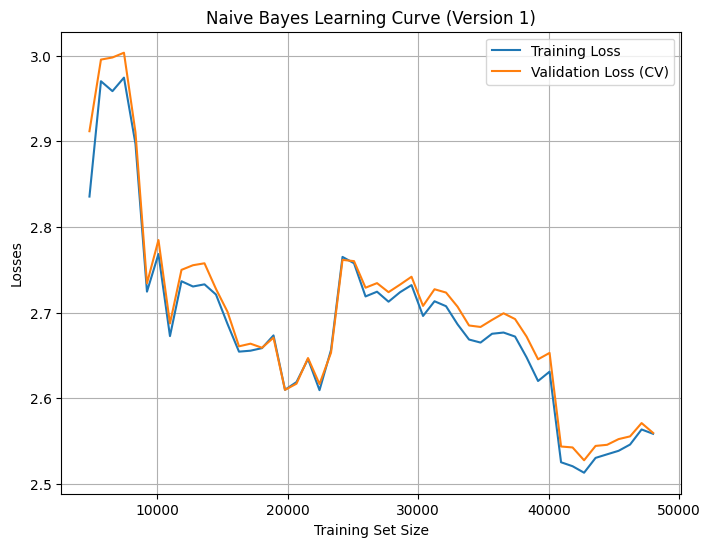

In [ ]:
# initialize the classifier
nb_best_params = {key.replace('estimator__', ''): value for key, value in nb_best_params.items()}
nb_classifier = MultiOutputClassifier(GaussianNB(**nb_best_params))

# ploting learning curve
plot_learning_curve(nb_classifier, X_train, y_train, 'Naive Bayes', "Version 1")

                                        NAIVE BAYES REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.8441     |   0.7386   |   0.7914
Test Accuracy:           0.8472     |   0.7368   |   0.7920
                            -       |      -     |      -
Training Loss:           4.3829     |   0.8435   |   2.6132
Test Loss:               4.3659     |   0.8049   |   2.6132


                                 < === Binary Classification Report === >

Precision: 0.9397
Recall: 0.7171
F1 Score: 0.8134
True Positive Rate: 0.7171
False Positive Rate: 0.1842



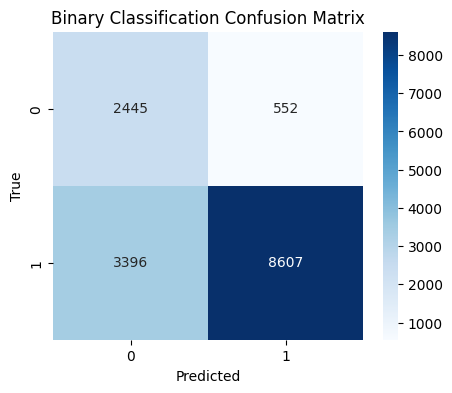

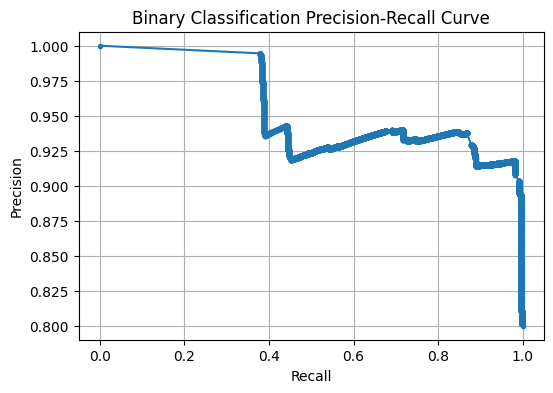



                           < === Multi-class Classification Report === >

Precision: 0.8608
Recall: 0.8472
F1 Score: 0.8427
True Positive Rate: 0.8470
False Positive Rate: 0.0383



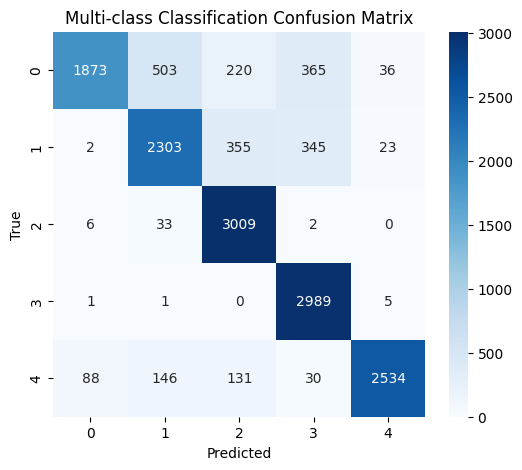

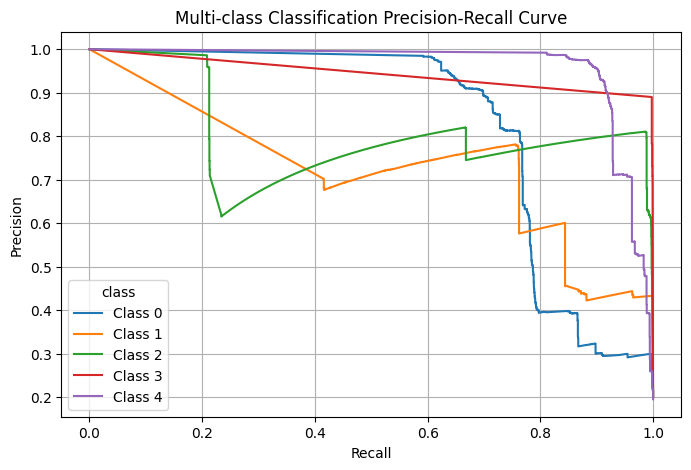



                               < === Average Classification Report === >

Precision: 0.9003
Recall: 0.7821
F1 Score: 0.8281
True Positive Rate: 0.7820
False Positive Rate: 0.1112


In [ ]:
# train the final model
nb_classifier.fit(X_train, y_train)

# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report_nb, multi_classification_report_nb, avg_classification_report_nb = check_metrics(nb_classifier, "Naive Bayes", X_train, y_train, X_test, y_test)

In [ ]:
# write into json file
save_classification_reports(binary_classification_report_nb, multi_classification_report_nb, avg_classification_report_nb, "Naive Bayes", (path + "v1_results.json"))

Data saved successfully!


In [ ]:
# saving model
joblib.dump(nb_classifier, (path + 'nb_classifier.pkl'))

['/content/drive/MyDrive/datasets/nb_classifier.pkl']

*****
*****
# AdaBoost

In [ ]:
# performing hyperparameter tuning for AdaBoost model
ada_param_grid = {
    'estimator__n_estimators': [50, 100, 150, 200],
    'estimator__learning_rate': [0.001, 0.01, 0.05, 0.1],
}

start = time.time()
ada_best_params = perform_hyperparameter_tuning(
    AdaBoostClassifier(random_state=42),
    ada_param_grid,
    X_train,
    y_train
)
measure_time((time.time()-start), "Ada Boost", True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'estimator__learning_rate': 0.001, 'estimator__n_estimators': 50}
Ada Boost Hyperparameter Tuning Time: 0h 17m 47s 



Train loss: 0.9427
Val loss: 0.9428


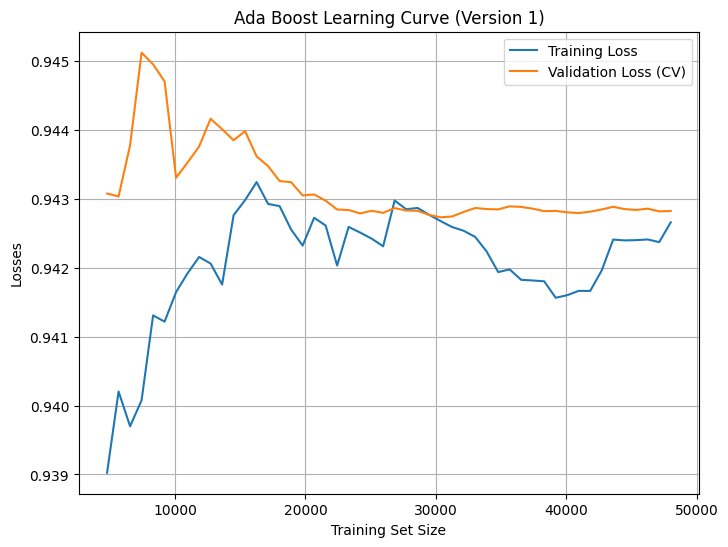

In [ ]:
# initialize the classifier
ada_best_params = {key.replace('estimator__', ''): value for key, value in ada_best_params.items()}
ada_classifier = MultiOutputClassifier(AdaBoostClassifier(**ada_best_params, random_state=42))

# ploting learning curve
plot_learning_curve(ada_classifier, X_train, y_train, 'Ada Boost', "Version 1")

                                        ADA BOOST REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.3675     |   0.9015   |   0.6345
Test Accuracy:           0.3602     |   0.9021   |   0.6312
                            -       |      -     |      -
Training Loss:           1.5615     |   0.3240   |   0.9427
Test Loss:               1.5630     |   0.3227   |   0.9427


                                 < === Binary Classification Report === >

Precision: 0.8911
Recall: 0.9999
F1 Score: 0.9424
True Positive Rate: 0.9999
False Positive Rate: 0.4895



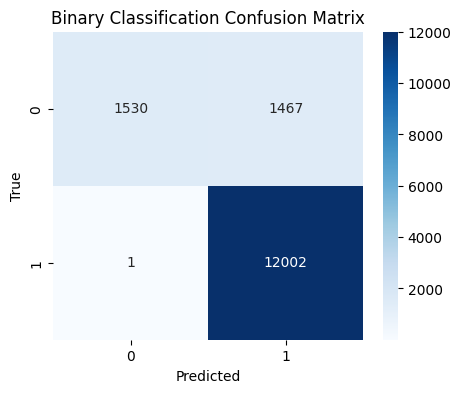

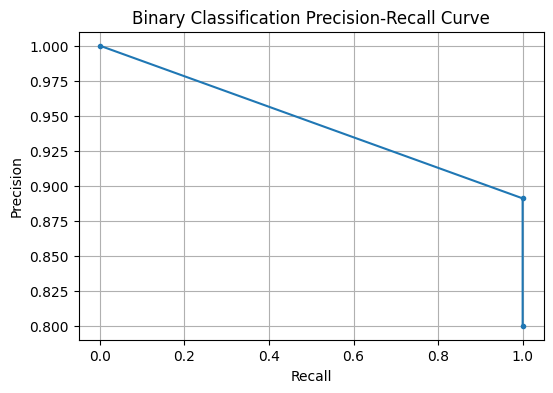



                           < === Multi-class Classification Report === >

Precision: 0.1645
Recall: 0.3602
F1 Score: 0.2171
True Positive Rate: 0.3643
False Positive Rate: 0.1597



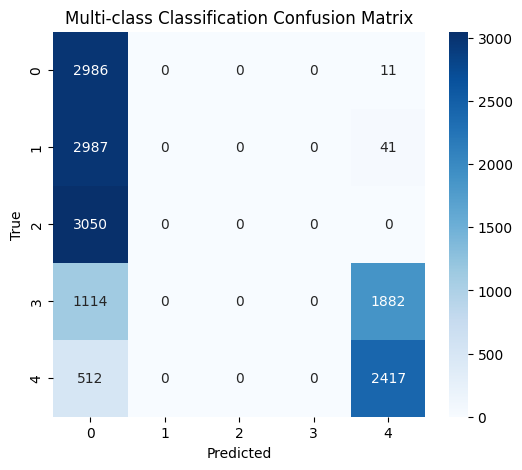

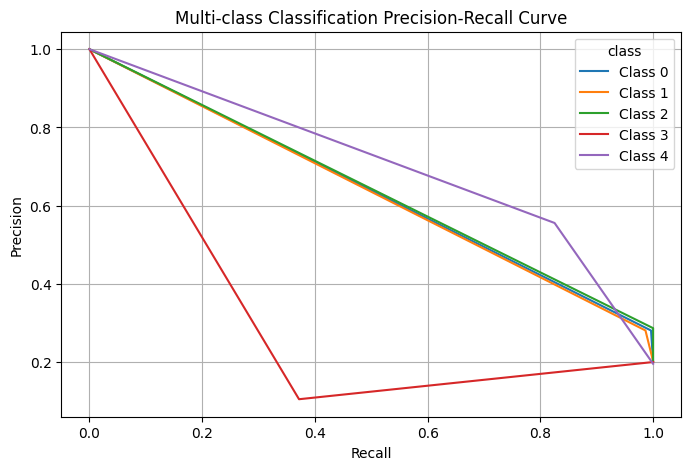



                               < === Average Classification Report === >

Precision: 0.5278
Recall: 0.6801
F1 Score: 0.5797
True Positive Rate: 0.6821
False Positive Rate: 0.3246


In [ ]:
# train the final model
ada_classifier.fit(X_train, y_train)

# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report_ada, multi_classification_report_ada, avg_classification_report_ada = check_metrics(ada_classifier, "Ada Boost", X_train, y_train, X_test, y_test)

In [ ]:
# write into json file
save_classification_reports(binary_classification_report_ada, multi_classification_report_ada, avg_classification_report_ada, "Ada Boost", (path + "v1_results.json"))

Data saved successfully!


In [ ]:
# saving model
joblib.dump(ada_classifier, (path + 'ada_classifier.pkl'))

['/content/drive/MyDrive/datasets/ada_classifier.pkl']

*****
*****
# KNN

In [ ]:
# performing hyperparameter tuning for KNN model
knn_param_grid = {
    'estimator__n_neighbors': [3, 5, 8, 10, 15, 20],
    'estimator__weights': ['uniform', 'distance'],
    'estimator__leaf_size': [10, 20, 30],
    'estimator__metric': ['euclidean', 'manhattan', 'chebyshev']
}
start = time.time()
knn_best_params = perform_hyperparameter_tuning(
    KNeighborsClassifier(),
    knn_param_grid,
    X_train,
    y_train
)
measure_time((time.time()-start), "KNN", True)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'estimator__leaf_size': 10, 'estimator__metric': 'euclidean', 'estimator__n_neighbors': 3, 'estimator__weights': 'uniform'}
KNN Hyperparameter Tuning Time: 4h 6m 8s 



Train loss: 0.1069
Val loss: 0.226


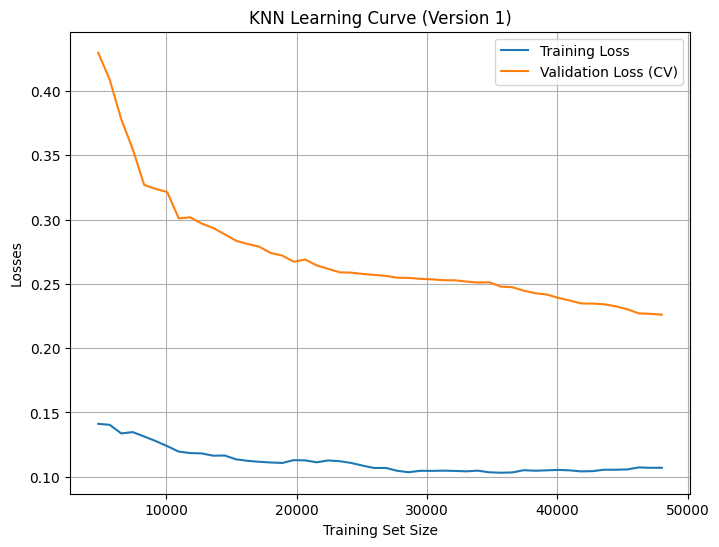

In [ ]:
# initialize the classifier
knn_best_params = {key.replace('estimator__', ''): value for key, value in knn_best_params.items()}
knn_classifier = MultiOutputClassifier(KNeighborsClassifier(**knn_best_params))

# ploting learning curve
plot_learning_curve(knn_classifier, X_train, y_train, 'KNN', "Version 1")

                                        KNN REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.9762     |   0.9812   |   0.9787
Test Accuracy:           0.9745     |   0.9799   |   0.9772
                            -       |      -     |      -
Training Loss:           0.1885     |   0.0313   |   0.1099
Test Loss:               0.3125     |   0.1285   |   0.1099


                                 < === Binary Classification Report === >

Precision: 0.9868
Recall: 0.9882
F1 Score: 0.9875
True Positive Rate: 0.9882
False Positive Rate: 0.0531



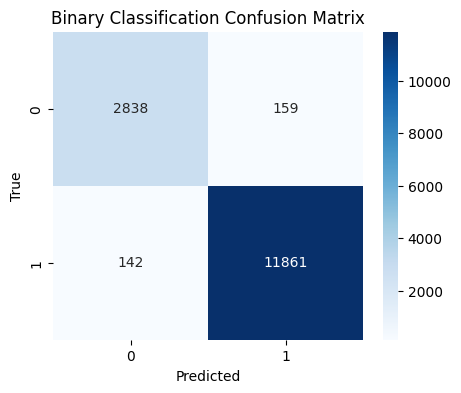

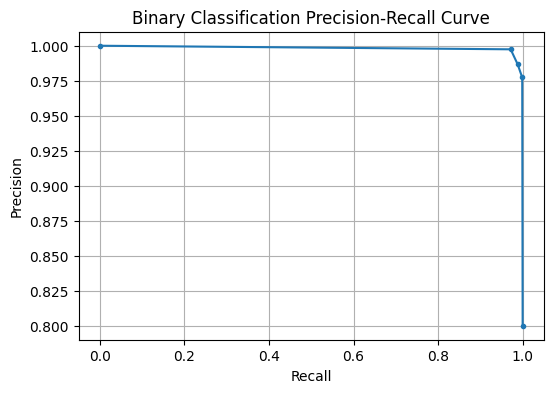



                           < === Multi-class Classification Report === >

Precision: 0.9748
Recall: 0.9745
F1 Score: 0.9746
True Positive Rate: 0.9746
False Positive Rate: 0.0064



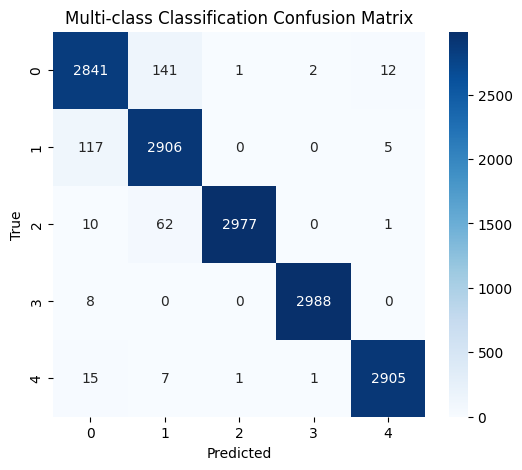

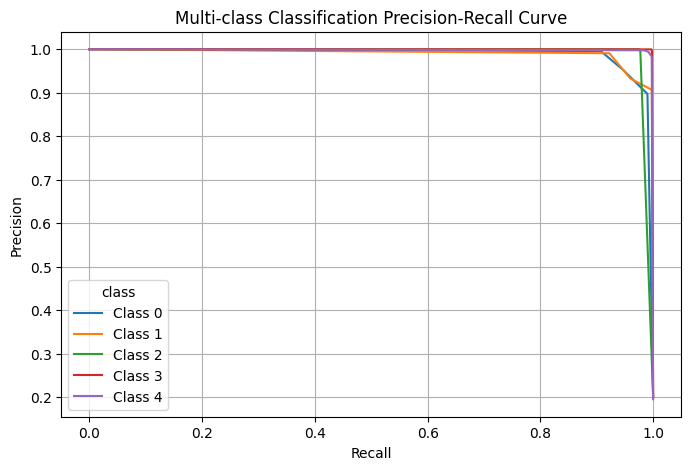



                               < === Average Classification Report === >

Precision: 0.9808
Recall: 0.9813
F1 Score: 0.9810
True Positive Rate: 0.9814
False Positive Rate: 0.0297


In [ ]:
# train the final model
knn_classifier.fit(X_train, y_train)

# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report_knn, multi_classification_report_knn, avg_classification_report_knn = check_metrics(knn_classifier, "KNN", X_train, y_train, X_test, y_test)

In [ ]:
# write into json file
save_classification_reports(binary_classification_report_knn, multi_classification_report_knn, avg_classification_report_knn, "KNN", (path + "v1_results.json"))

Data saved successfully!


In [ ]:
# saving model
joblib.dump(knn_classifier, (path + 'knn_classifier.pkl'))

['/content/drive/MyDrive/datasets/knn_classifier.pkl']

*****
*****
# Multi Layer Perceptron

### Create Custom Dataset Class for multi-label dataset

In [ ]:
class MultiLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y_multi = torch.LongTensor(y['Attack Type'].values)
        self.y_binary = torch.FloatTensor(y['status'].values).unsqueeze(1)

    def __len__(self):
        return self.X.shape[0] # return the sample size

    def __getitem__(self, idx):
        return self.X[idx], self.y_multi[idx], self.y_binary[idx]

### Creating Dynamic Network

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layers, dropout_rate=0.2):
        super(MultiLayerPerceptron, self).__init__()

        layers = []

        # hidden layers
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, neurons_per_layers))
            layers.append(nn.BatchNorm1d(neurons_per_layers))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = neurons_per_layers

        self.network = nn.Sequential(*layers) # create the network

        self.multi_output = nn.Linear(neurons_per_layers, output_dim)   # multiclass output
        self.binary_output = nn.Sequential(   # binary output
            nn.Linear(neurons_per_layers, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.network(x)
        multi_class_out = self.multi_output(features)
        binary_out = self.binary_output(features)
        return multi_class_out, binary_out


### Hyper Parameter Tuning

In [ ]:
def objective(trial, train_dataset, val_dataset, input_dim, output_dim, device):
    # suggested parameters
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 2, 10)
    neurons_per_layers = trial.suggest_int('neurons_per_layers', 32, 512, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5, step=0.05)
    num_epochs = trial.suggest_int('num_epochs', 20, 100, step=20)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    #learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005, 0.00005])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'SGD', 'RMSprop'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # init model
    model = MultiLayerPerceptron(
        input_dim = input_dim,
        output_dim = output_dim,
        num_hidden_layers = num_hidden_layers,
        neurons_per_layers = neurons_per_layers,
        dropout_rate = dropout_rate
    ).to(device)

    # define loss functions and optimizer with weight decay
    criterion_multi = nn.CrossEntropyLoss()
    criterion_binary = nn.BCELoss()

    # select optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.0, 0.9)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # train the model
    _, history = train_model(
        model = model,
        train_loader = train_loader,
        val_loader = val_loader,
        criterion_multi = criterion_multi,
        criterion_binary = criterion_binary,
        optimizer = optimizer,
        scheduler = scheduler,
        num_epochs = num_epochs,
        device = device,
        tune=True
    )

    # return the best validation loss as the objective to minimize
    best_val_loss = min(history['val_losses'])
    return best_val_loss

In [ ]:
def tune_hyperparameters(train_dataset, val_dataset, input_dim, output_dim, device, n_trials=100):
    """ perform hyperparameter tuning using optuna """
    # create optuna study with minimize validation loss
    study = optuna.create_study(direction='minimize')
    start = time.time()
    study.optimize(
        lambda trial: objective(trial, train_dataset, val_dataset, input_dim, output_dim, device),
        n_trials=n_trials,
        n_jobs=3,
        show_progress_bar=True
    )
    measure_time((time.time()-start), "MLP", True)
    print("Number of finished trials:", len(study.trials))
    print("Best trial: ")
    trial = study.best_trial

    print(f"Validation Loss: {trial.value:4f}")
    print("Best Parameters: ")
    for key, value in trial.params.items():
        print(f" {key}: {value}")

    return study.best_params

### Training Function

In [ ]:
def train_epoch(model, data_loader, criterion_multi, criterion_binary, optimizer=None, is_training=True, device='cuda'):
    """ this function contain the model training evaluation epoch loop to reduce code redundant """
    total_loss = 0
    correct_multi = 0
    correct_binary = 0
    total_samples = 0

    # Set model mode (train or eval)
    model.train() if is_training else model.eval()

    for batch_X, batch_y_multi, batch_y_binary in data_loader:
        batch_X, batch_y_multi, batch_y_binary = batch_X.to(device), batch_y_multi.to(device), batch_y_binary.to(device)

        # forward pass
        pred_multi, pred_binary = model(batch_X)

        # calculate loss
        loss_multi = criterion_multi(pred_multi, batch_y_multi)
        loss_binary = criterion_binary(pred_binary, batch_y_binary)
        loss = loss_multi + loss_binary

        if is_training:
            # bacward pass
            optimizer.zero_grad()
            loss.backward()
            # update grad
            optimizer.step()

        # calculate total epoch loss and accuracy
        total_loss += loss.item()
        _, predicted_multi = torch.max(pred_multi, 1)
        predicted_binary = (pred_binary > 0.5).float()

        correct_multi += (predicted_multi == batch_y_multi).sum().item()
        correct_binary += (predicted_binary == batch_y_binary).sum().item()
        total_samples += batch_y_multi.size(0)

    avg_loss = total_loss / len(data_loader)
    acc_multi = correct_multi / total_samples
    acc_binary = correct_binary / total_samples
    acc_avg = (acc_multi + acc_binary) / 2

    return avg_loss, acc_multi, acc_binary, acc_avg

In [ ]:
def train_model(model, train_loader, val_loader, criterion_multi, criterion_binary, optimizer, scheduler, num_epochs, device, patience=5, tune=False):
    # total training losses & accuracy
    train_losses = []
    train_acc_multi = []
    train_acc_binary = []
    train_acc_avg = []

    # total validation losses and accuracy
    val_losses = []
    val_acc_multi = []
    val_acc_binary = []
    val_acc_avg = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    # trainig loop
    for epoch in range(num_epochs):
        avg_train_loss, acc_train_multi, acc_train_binary, acc_train_avg = train_epoch(
            model,
            train_loader,
            criterion_multi,
            criterion_binary,
            optimizer=optimizer,
            is_training=True,
            device=device
        )

        # store training metrics
        train_losses.append(avg_train_loss)
        train_acc_multi.append(acc_train_multi)
        train_acc_binary.append(acc_train_binary)
        train_acc_avg.append(acc_train_avg)

        # validation phase
        avg_val_loss, acc_val_multi, acc_val_binary, acc_val_avg = train_epoch(
            model,
            val_loader,
            criterion_multi,
            criterion_binary,
            optimizer=None,
            is_training=False,
            device=device
        )

        # store validation metrics
        val_losses.append(avg_val_loss)
        val_acc_multi.append(acc_val_multi)
        val_acc_binary.append(acc_val_binary)
        val_acc_avg.append(acc_val_avg)

        if tune==False:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc Avg: {train_acc_avg[-1]:.4f}, Val Acc Avg: {val_acc_avg[-1]:.4f}, Train Acc Multi: {train_acc_multi[-1]:.4f}, Train Acc Binary: {train_acc_binary[-1]:.4f}, Val Acc Multi: {val_acc_multi[-1]:.4f}, Val Acc Binary: {val_acc_binary[-1]:.4f}")

        # step the scheduler based on validation loss
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())  # saving the best model weights
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epoch > 10 and epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    model.load_state_dict(best_model_wts)   # loading the best model weights

    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc_multi': train_acc_multi,
        'train_acc_binary': train_acc_binary,
        'train_acc_avg': train_acc_avg,
        'val_acc_multi': val_acc_multi,
        'val_acc_binary': val_acc_binary,
        'val_acc_avg': val_acc_avg
    }
    return model, history


In [ ]:
def train_final_model(model, train_loader, criterion_multi, criterion_binary, optimizer, num_epochs, device):
    """ train the final model on the training dataset only """
    train_losses = []
    train_acc_multi = []
    train_acc_binary = []
    train_acc_avg = []

    # Training loop (no validation)
    for epoch in range(num_epochs):
        avg_train_loss, acc_train_multi, acc_train_binary, acc_train_avg = train_epoch(
            model,
            train_loader,
            criterion_multi,
            criterion_binary,
            optimizer=optimizer,
            is_training=True,
            device=device
        )

        train_losses.append(avg_train_loss)
        train_acc_multi.append(acc_train_multi)
        train_acc_binary.append(acc_train_binary)
        train_acc_avg.append(acc_train_avg)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc Avg: {acc_train_avg:.4f}, Train Acc Multi: {acc_train_multi:.4f}, Train Acc Binary: {acc_train_binary:.4f}")

    history = {
        'train_losses': train_losses,
        'train_acc_multi': train_acc_multi,
        'train_acc_binary': train_acc_binary,
        'train_acc_avg': train_acc_avg
    }

    return model, history


### Training Phase

In [ ]:
# perform hyper parameter tuning
train_dataset = MultiLabelDataset(X_train, y_train)
test_dataset = MultiLabelDataset(X_test, y_test)

# init parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train['Attack Type']))

start = time.time()
best_params = tune_hyperparameters(
    train_dataset,
    test_dataset,
    input_size,
    output_size,
    device
)
measure_time((time.time()-start), "MLP", True)

[I 2025-04-03 05:01:07,348] A new study created in memory with name: no-name-667c4b3c-758f-42b9-8959-3b14ffa9f087


  0%|          | 0/100 [00:00<?, ?it/s]

Early stopping triggered after 31 epochs
[I 2025-04-03 05:14:22,087] Trial 0 finished with value: 0.25573999717084966 and parameters: {'num_hidden_layers': 4, 'neurons_per_layers': 96, 'dropout_rate': 0.35, 'num_epochs': 60, 'learning_rate': 7.644587595229314e-05, 'batch_size': 32, 'weight_decay': 4.965841762448596e-05, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: 0.25573999717084966.
Early stopping triggered after 16 epochs
[I 2025-04-03 05:18:35,878] Trial 3 finished with value: 0.28616156314915797 and parameters: {'num_hidden_layers': 6, 'neurons_per_layers': 224, 'dropout_rate': 0.45, 'num_epochs': 20, 'learning_rate': 0.0015597446893261808, 'batch_size': 64, 'weight_decay': 0.006817672059605273, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: 0.25573999717084966.
[I 2025-04-03 05:21:22,961] Trial 1 finished with value: 0.29954302977564046 and parameters: {'num_hidden_layers': 8, 'neurons_per_layers': 512, 'dropout_rate': 0.35, 'num_epochs': 20, 'learning_rat

In [ ]:
# initialize final model with best parameters
model = MultiLayerPerceptron(
    input_dim = input_size,
    output_dim = output_size,
    num_hidden_layers = best_params['num_hidden_layers'],
    neurons_per_layers = best_params['neurons_per_layers'],
    dropout_rate = best_params['dropout_rate']
).to(device)

# model training with best parameters to track the model lerning performance
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, pin_memory=True)

optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay']) # l2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

criterion_multi = nn.CrossEntropyLoss()
criterion_binary = nn.BCELoss()

In [ ]:
# train the model to track the learning performance
start = time.time()
_, final_history = train_model(
    model,
    train_loader,
    test_loader,
    criterion_multi,
    criterion_binary,
    optimizer,
    scheduler,
    best_params['num_epochs'],
    device
)
measure_time((time.time()-start), "MLP")

Epoch [1/40], Train Loss: 0.5213, Val Loss: 0.3419, Train Acc Avg: 0.9065, Val Acc Avg: 0.9514, Train Acc Multi: 0.8872, Train Acc Binary: 0.9258, Val Acc Multi: 0.9459, Val Acc Binary: 0.9569
Epoch [2/40], Train Loss: 0.3277, Val Loss: 0.2918, Train Acc Avg: 0.9382, Val Acc Avg: 0.9474, Train Acc Multi: 0.9312, Train Acc Binary: 0.9453, Val Acc Multi: 0.9395, Val Acc Binary: 0.9553
Epoch [3/40], Train Loss: 0.2826, Val Loss: 0.2509, Train Acc Avg: 0.9469, Val Acc Avg: 0.9566, Train Acc Multi: 0.9413, Train Acc Binary: 0.9525, Val Acc Multi: 0.9510, Val Acc Binary: 0.9623
Epoch [4/40], Train Loss: 0.2584, Val Loss: 0.2124, Train Acc Avg: 0.9507, Val Acc Avg: 0.9626, Train Acc Multi: 0.9459, Train Acc Binary: 0.9555, Val Acc Multi: 0.9603, Val Acc Binary: 0.9649
Epoch [5/40], Train Loss: 0.2432, Val Loss: 0.2347, Train Acc Avg: 0.9534, Val Acc Avg: 0.9535, Train Acc Multi: 0.9488, Train Acc Binary: 0.9581, Val Acc Multi: 0.9495, Val Acc Binary: 0.9574
Epoch [6/40], Train Loss: 0.2301, V

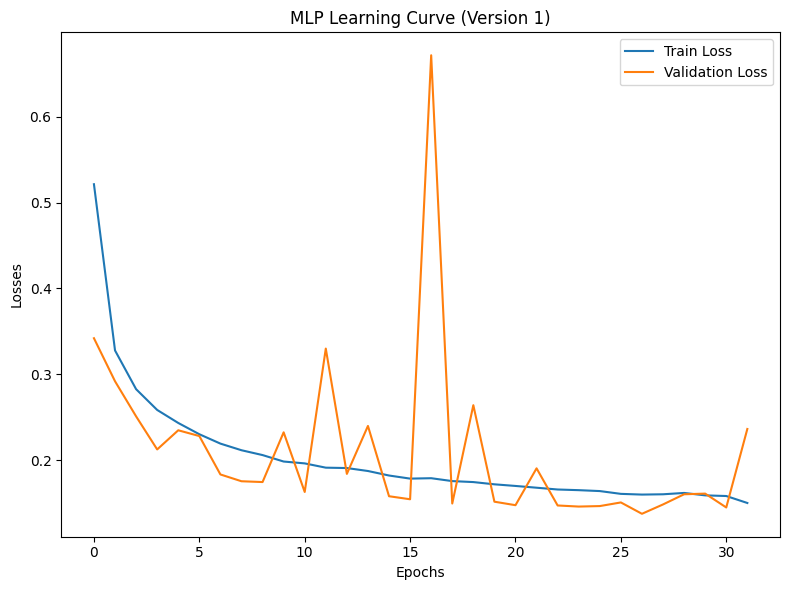

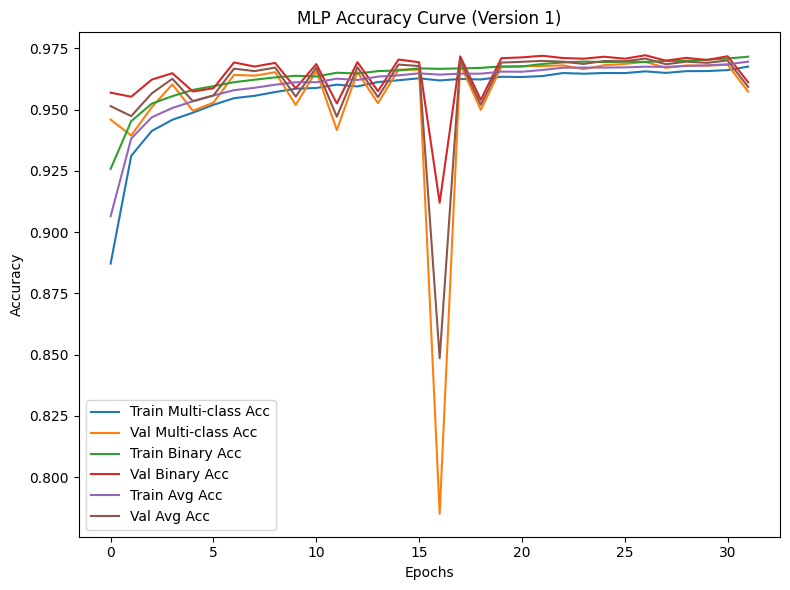

In [ ]:
# ploting the learning curves
plot_learning_curves(final_history, "MLP", "Version 1")

In [ ]:
# train the final model on the training data only
start = time.time()
mlp_classifier, final_history = train_final_model(
    model,
    train_loader,
    criterion_multi,
    criterion_binary,
    optimizer,
    40,
    device
)

measure_time((time.time()-start), "MLP")

Epoch [1/40], Train Loss: 0.1504, Train Acc Avg: 0.9695, Train Acc Multi: 0.9672, Train Acc Binary: 0.9717
Epoch [2/40], Train Loss: 0.1485, Train Acc Avg: 0.9695, Train Acc Multi: 0.9673, Train Acc Binary: 0.9716
Epoch [3/40], Train Loss: 0.1475, Train Acc Avg: 0.9698, Train Acc Multi: 0.9681, Train Acc Binary: 0.9715
Epoch [4/40], Train Loss: 0.1453, Train Acc Avg: 0.9699, Train Acc Multi: 0.9679, Train Acc Binary: 0.9720
Epoch [5/40], Train Loss: 0.1454, Train Acc Avg: 0.9701, Train Acc Multi: 0.9678, Train Acc Binary: 0.9724
Epoch [6/40], Train Loss: 0.1449, Train Acc Avg: 0.9707, Train Acc Multi: 0.9685, Train Acc Binary: 0.9729
Epoch [7/40], Train Loss: 0.1456, Train Acc Avg: 0.9704, Train Acc Multi: 0.9684, Train Acc Binary: 0.9724
Epoch [8/40], Train Loss: 0.1450, Train Acc Avg: 0.9705, Train Acc Multi: 0.9683, Train Acc Binary: 0.9727
Epoch [9/40], Train Loss: 0.1430, Train Acc Avg: 0.9704, Train Acc Multi: 0.9684, Train Acc Binary: 0.9724
Epoch [10/40], Train Loss: 0.1422, Tr

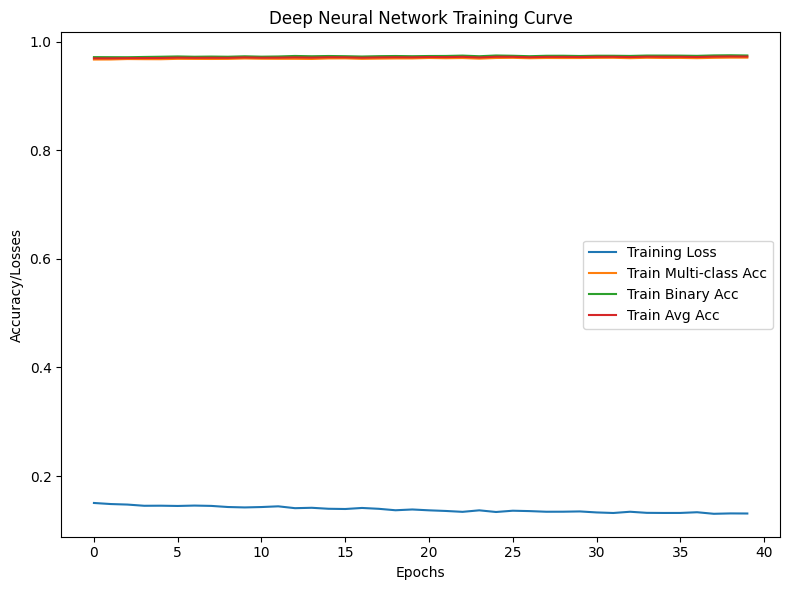

In [ ]:
# plot the final model training curve
plot_training_curve(final_history)

In [ ]:
# checking the model
summary(mlp_classifier, input_size=(1,input_size))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerPerceptron                     [1, 5]                    --
├─Sequential: 1-1                        [1, 448]                  --
│    └─Linear: 2-1                       [1, 448]                  12,992
│    └─BatchNorm1d: 2-2                  [1, 448]                  896
│    └─ReLU: 2-3                         [1, 448]                  --
│    └─Dropout: 2-4                      [1, 448]                  --
│    └─Linear: 2-5                       [1, 448]                  201,152
│    └─BatchNorm1d: 2-6                  [1, 448]                  896
│    └─ReLU: 2-7                         [1, 448]                  --
│    └─Dropout: 2-8                      [1, 448]                  --
│    └─Linear: 2-9                       [1, 448]                  201,152
│    └─BatchNorm1d: 2-10                 [1, 448]                  896
│    └─ReLU: 2-11                        [1, 448]                  -

                                        MLP REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.9565     |   0.9601   |   0.9583
Test Accuracy:           0.9560     |   0.9596   |   0.9578
                            -       |      -     |      -
Training Loss:           0.1640     |   0.1186   |   0.1413
Test Loss:               0.1663     |   0.1192   |   0.1413


                                 < === Binary Classification Report === >

Precision: 0.9851
Recall: 0.9641
F1 Score: 0.9745
True Positive Rate: 0.9641
False Positive Rate: 0.0584



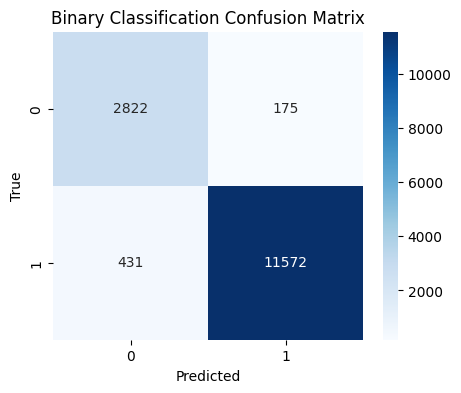

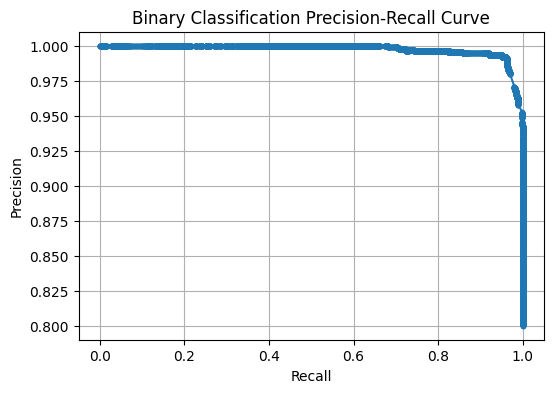



                           < === Multi-class Classification Report === >

Precision: 0.9584
Recall: 0.9560
F1 Score: 0.9564
True Positive Rate: 0.9561
False Positive Rate: 0.0110



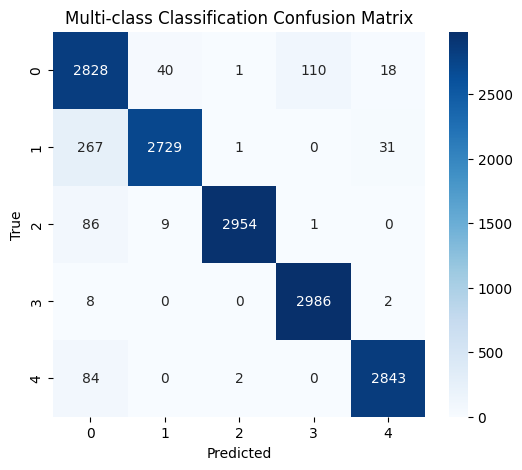

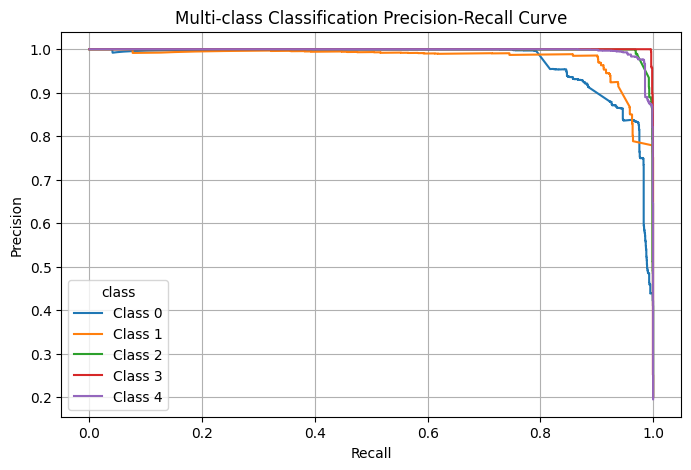



                               < === Average Classification Report === >

Precision: 0.9718
Recall: 0.9600
F1 Score: 0.9654
True Positive Rate: 0.9601
False Positive Rate: 0.0347


In [ ]:
# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report_mlp, multi_classification_report_mlp, avg_classification_report_mlp = evaluate_dnn_result(mlp_classifier, "MLP", train_loader, test_loader, output_size, device)

In [ ]:
# write into json file
save_classification_reports(binary_classification_report_mlp, multi_classification_report_mlp, avg_classification_report_mlp, "MLP", (path + "v1_results.json"))

Data saved successfully!


In [ ]:
# saving model & state dict
torch.save(mlp_classifier, (path + "mlp_classifier.pth"))
torch.save(mlp_classifier.state_dict(), (path + "mlp_classifier_states.pth"))

*****
*****
# Ensembble Model (Multi-model: Decision Tree + Random Forest)

### Model

In [148]:
class EnsembbleModel:
    def __init__(self, models):
        self.models = models
        self.model_predictions = {}
        self.weights = {}
        self.n_classes_multi = None

    def multi_log_loss(self, y, y_probas):
        loss1 = log_loss(y.iloc[:, 0], y_probas[0], normalize=True)
        loss2 = log_loss(y.iloc[:, 1], y_probas[1], normalize=True)
        return (loss1 + loss2) / 2

    def fit(self, X, y):
        self.X = X
        self.n_classes_multi = len(np.unique(y.iloc[:,0]))
        for name, model in self.models.items():
            probas = model.predict_proba(X)
            self.model_predictions[name] = probas

            ll = self.multi_log_loss(y, probas)
            self.weights[name] = 1 / ll if ll > 0 else 1.0  # inverse log loss as weight
            #print(f"{name} Loss: {ll:.4f}")    # tracing

        total_weight = sum(self.weights.values())
        for name in self.weights:
            self.weights[name] /= total_weight
            #print(f"{name} Weight: {self.weights[name]:.4f}")      # tracing
        #print(f'total: {sum(self.weights.values())}')      # tracing

    def predict_proba(self, X):
        n_samples = len(X)
        n_classes_multi = self.n_classes_multi

        # init probability arrays for both outputs
        proba_multi = np.zeros((n_samples, n_classes_multi))
        proba_binary = np.zeros((n_samples, 2))

        # for name in self.models:
        #     multi_pred, binary_pred = self.model_predictions[name]
        for name, model in self.models.items():
            multi_pred, binary_pred = model.predict_proba(X)

            # Apply weights to each output separately
            proba_multi += self.weights[name] * multi_pred
            proba_binary += self.weights[name] * binary_pred

        return proba_multi, proba_binary

    def predict(self, X):
        proba_multi, proba_binary = self.predict_proba(X)

        # Get final predictions for both outputs
        pred_multi = np.argmax(proba_multi, axis=1)
        pred_binary = np.argmax(proba_binary, axis=1)

        # Combine predictions into final output
        return np.column_stack((pred_multi, pred_binary))

    def get_weights(self):
        for name in self.weights:
            print(f"{name} Weight: {self.weights[name]:.4f}")
        return self.weights

    def get_models(self):
        return self.models

### Init

In [149]:
# load best 2 models
dt = joblib.load(path+'dt_classifier.pkl')
rf = joblib.load(path+'rf_classifier.pkl')

models = {
    "Decision Tree": dt,
    "Random Forest": rf
}

In [150]:
em_classifier = EnsembbleModel(models)
em_classifier.fit(X_test, y_test)
print(em_classifier.predict_proba(X_test))
em_classifier.predict(X_test)

(array([[1.26392200e-03, 2.56874403e-04, 9.98312418e-01, 0.00000000e+00,
        1.66785454e-04],
       [9.98659027e-01, 7.38611728e-04, 2.82257565e-04, 1.25359681e-04,
        1.94743685e-04],
       [2.58236038e-02, 9.24540371e-01, 3.87650964e-02, 4.02491495e-03,
        6.84601412e-03],
       ...,
       [1.82547443e-02, 9.79793728e-01, 9.94144955e-04, 5.31126515e-05,
        9.04269820e-04],
       [8.47719231e-04, 1.03635214e-04, 9.98925919e-01, 0.00000000e+00,
        1.22726199e-04],
       [1.16958376e-03, 0.00000000e+00, 2.59646719e-05, 9.98390100e-01,
        4.14352061e-04]]), array([[0.02572314, 0.97427686],
       [0.99888851, 0.00111149],
       [0.04328677, 0.95671323],
       ...,
       [0.03245578, 0.96754422],
       [0.02311589, 0.97688411],
       [0.02540308, 0.97459692]]))


array([[2, 1],
       [0, 0],
       [1, 1],
       ...,
       [1, 1],
       [2, 1],
       [3, 1]])

In [153]:
em_classifier.get_weights()

Decision Tree Weight: 0.3723
Random Forest Weight: 0.6277


{'Decision Tree': 0.37233227893915843, 'Random Forest': 0.6276677210608416}

                                        ENSEMBLE (DT + RF) REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.9740     |   0.9701   |   0.9720
Test Accuracy:           0.9729     |   0.9695   |   0.9712
                            -       |      -     |      -
Training Loss:           0.0667     |   0.0689   |   0.0678
Test Loss:               0.0708     |   0.0702   |   0.0678


                                 < === Binary Classification Report === >

Precision: 0.9652
Recall: 0.9978
F1 Score: 0.9812
True Positive Rate: 0.9978
False Positive Rate: 0.1441



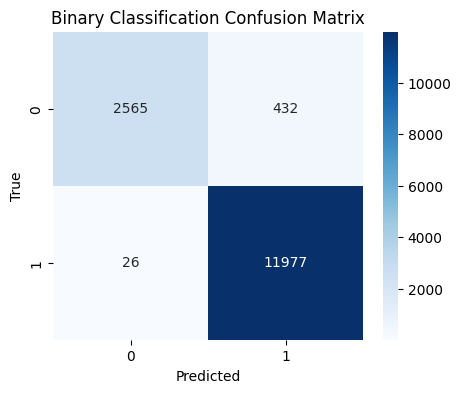

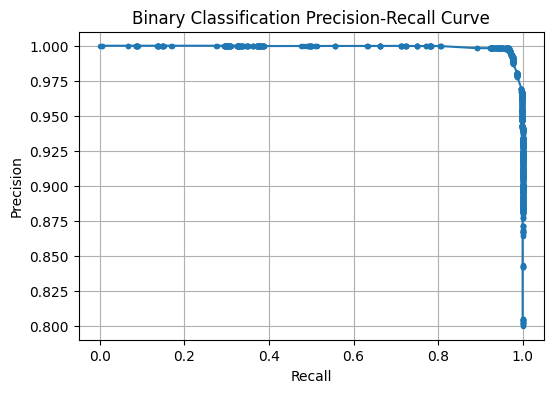



                           < === Multi-class Classification Report === >

Precision: 0.9731
Recall: 0.9729
F1 Score: 0.9729
True Positive Rate: 0.9730
False Positive Rate: 0.0068



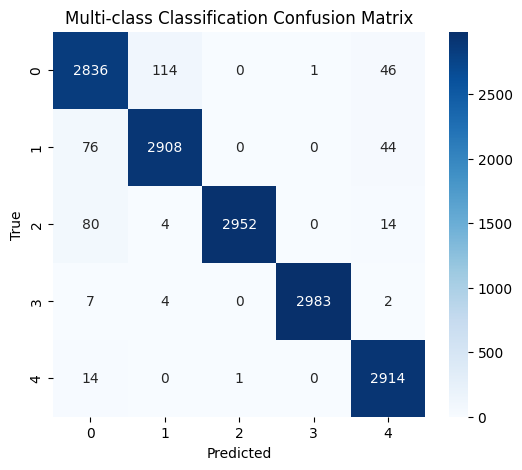

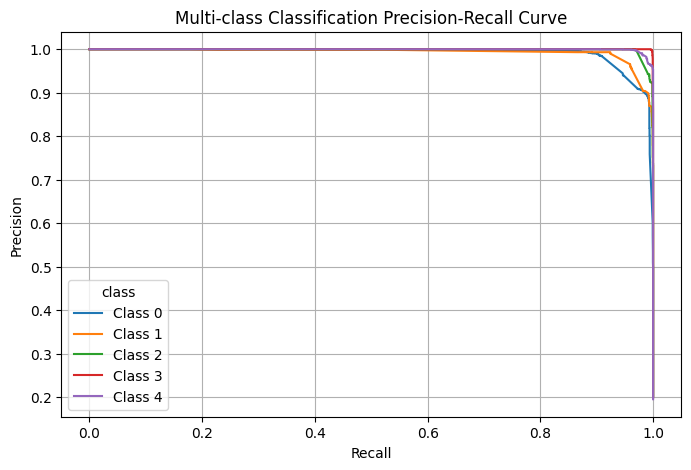



                               < === Average Classification Report === >

Precision: 0.9692
Recall: 0.9854
F1 Score: 0.9771
True Positive Rate: 0.9854
False Positive Rate: 0.0755


In [154]:
binary_classification_report_em, multi_classification_report_em, avg_classification_report_em = check_metrics(
    em_classifier,
    "Ensemble (DT + RF)",
    X_train, y_train,
    X_test, y_test
)

In [155]:
# write into json file
save_classification_reports(binary_classification_report_em, multi_classification_report_em, avg_classification_report_em, "Ensemble (DT + RF)", (path + "v1_results.json"))

Data saved successfully!


In [156]:
# saving model
joblib.dump(em_classifier, (path + 'em_classifier.pkl'))

['/content/drive/MyDrive/datasets/v1/em_classifier.pkl']

In [157]:
new = np.array([-0.5167465,-0.23895831,-0.27658543,0.91072595,0.107771985,-0.07033271,-0.500595,-0.059034027,0.98242116,-0.4942193,-0.47477624,-0.1439801,-0.16323264,0.47076535,0.8364966,-0.15879062,0.33294824,0.60117346,-0.115961015,-0.25609934,-0.6057088,-0.70278895,-0.5434224,0.647265,-0.37351826,0.25464302,-0.39324358,-0.30745706]).reshape(1,-1)
em_classifier.predict(new)

array([[2, 1]])

# **This notebook was run on Google Colab, so there might be directory mismatch issues**